# Dependencies

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [65]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [57]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, figsize=(15,8))  # fontsize of the figure title

# IPF Demo

## Setup

First we'll generate some data, and for any data that is lower than some minimum threshold, we'll replace it with a random seed:

In [237]:
RANGE = (1, 20)
MIN_VALUE = 5
SIZE = (5,5)

# Generate some original data
original_data = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=SIZE))

# Any value less than MIN_VALUE is going to be suppressed.
missing_value_mask = original_data < MIN_VALUE
missing_values = original_data[missing_value_mask]

# Calculate the totals before we suppress.
column_totals = np.sum(original_data, axis=0)
row_totals = np.sum(original_data, axis=1)


# Replace the suppressed numbers with a random number in the interval [0, MIN_VALUE]
suppressed_data = np.copy(original_data)
suppressed_data[missing_value_mask] = np.rint(np.random.uniform(low=1, high=MIN_VALUE, size=missing_values.shape))

In [241]:
print(missing_values)
print(suppressed_data[missing_value_mask])

[ 4.  2.  3.]
[ 2.  3.  2.]


Let's take a look at how far off our random seeds are:

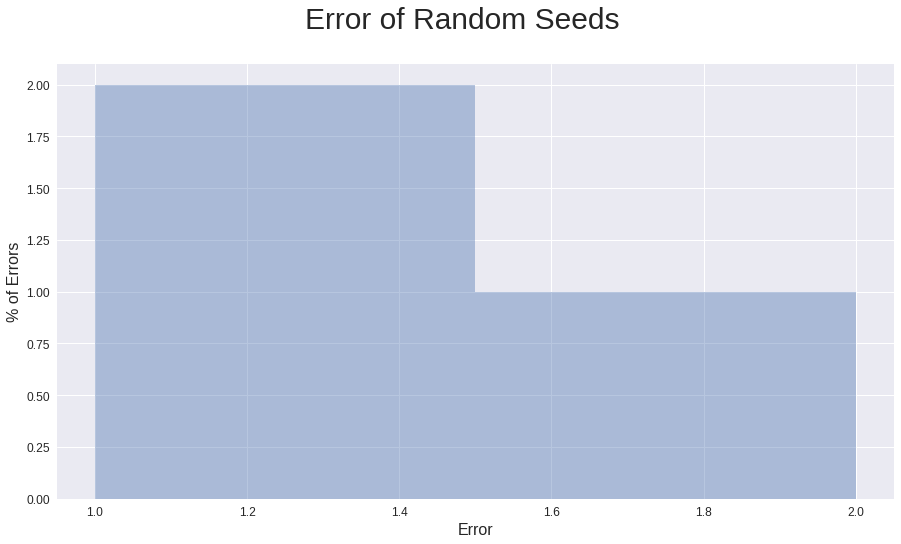

In [243]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error of Random Seeds")
plt.ylabel("% of Errors")
plt.xlabel("Error")
plt.show()

In [68]:
stats.describe(errors)

DescribeResult(nobs=8, minmax=(4.0, 9.0), mean=5.75, variance=2.7857142857142856, skewness=0.8129583193181347, kurtosis=-0.193293885601578)

## IPF

In [246]:
CONVERGENCE_THRESHOLD = 1e-5
MAX_ITERATIONS = 1000

delta = CONVERGENCE_THRESHOLD + 1
i = 0

while delta > CONVERGENCE_THRESHOLD and i < MAX_ITERATIONS:
    before = suppressed_data[missing_value_mask]
    
    current_row_totals = np.sum(suppressed_data, axis=1)
    current_column_totals = np.sum(suppressed_data, axis=0)
    
    for row in range(SIZE[0]):
        missing_indexes = missing_value_mask[row, :]    
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] / current_row_totals[row] 
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] * row_totals[row]

    for col in range(SIZE[1]):
        missing_indexes = missing_value_mask[:, col]    
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] / current_column_totals[col] 
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] * column_totals[col]    
    
    after = suppressed_data[missing_value_mask]
    delta = np.sum(np.abs(after-before))
    i += 1

In [247]:
print(missing_values)
print(suppressed_data[missing_value_mask])

[ 4.  2.  3.]
[ 4.          2.00012591  2.99988057]
